In [49]:
#Long Short Strategy

import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    return df

def trading_algorithm(df, threshold):
    initial_investment = 10000
    cumulative_pnl = 0
    total_investments = 0
    pnl_over_time = []
    log = []
    pending_pnl = {}

    df = df.sort_values(by='date')

    df = df.set_index('date').resample('W-FRI', label='left', closed='left').apply(lambda x: x)
    df = df.reset_index()

    weekly_dates = df['date'].unique()

    for date in weekly_dates:
        # Realize PnL for expiring options
        if date in pending_pnl:
            cumulative_pnl += pending_pnl[date]
            del pending_pnl[date]

        weekly_df = df[df['date'] == date]
        qualifying_straddles = weekly_df[weekly_df['predicted_mean_daily_delta_neutral_long_straddle_returns'] > threshold]

        if not qualifying_straddles.empty:
            num_straddles = len(qualifying_straddles)
            investment_per_straddle = initial_investment / num_straddles
            total_invested = 0
            total_contracts = 0
            total_weekly_returns = 0
            num_2_week_straddles = 0
            num_4_week_straddles = 0

            for _, straddle in qualifying_straddles.iterrows():
                straddle_cost = straddle['mid_call'] + straddle['mid_put']
                amount_invested = investment_per_straddle
                num_contracts = amount_invested / straddle_cost if straddle_cost > 0 else 0
                actual_return = straddle['delta_neutral_long_straddle_returns'] / 100
                trade_return = amount_invested * actual_return

                total_invested += amount_invested
                total_contracts += num_contracts
                total_weekly_returns += trade_return

                expiration_date = date + pd.DateOffset(weeks=4) if straddle['4_week_option'] == 1 else date + pd.DateOffset(weeks=2)
                if expiration_date not in pending_pnl:
                    pending_pnl[expiration_date] = 0
                pending_pnl[expiration_date] += trade_return

                if straddle['4_week_option'] == 1:
                    num_4_week_straddles += 1
                else:
                    num_2_week_straddles += 1

            total_investments += initial_investment
            total_weekly_return_percentage = (total_weekly_returns / initial_investment) * 100

            weekly_log = {
                'week_start_date': date,
                'num_straddles_longed': num_straddles,
                'num_2_week_straddles_longed': num_2_week_straddles,
                'num_4_week_straddles_longed': num_4_week_straddles,
                'total_amount_invested': total_invested,
                'total_num_contracts_bought': total_contracts,
                'total_returns_once_all_options_expire_dollars': total_weekly_returns,
                'total_returns_once_all_options_expire_percentage': total_weekly_return_percentage
            }
            log.append(weekly_log)

        pnl_over_time.append({'date': date, 'cumulative_pnl': cumulative_pnl})

    total_return_dollars = cumulative_pnl
    total_return_percentage = (cumulative_pnl / total_investments) * 100 if total_investments > 0 else 0
    return total_investments, total_return_dollars, total_return_percentage, log, pnl_over_time

def plot_pnl(pnl_over_time):
    dates = [entry['date'] for entry in pnl_over_time]
    pnl_values = [entry['cumulative_pnl'] for entry in pnl_over_time]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, pnl_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Date')
    plt.ylabel('PnL ($)')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.show()

def run_backtest(data_path, threshold_level):
    df = load_data(data_path)
    total_investments, total_return_dollars, total_return_percentage, log, pnl_over_time = trading_algorithm(df, threshold_level)
    
    print(f"Total Amount Invested: ${total_investments:.2f}")
    print(f"Total Returns: ${total_return_dollars:.2f}")
    print(f"Total Return Percentage: {total_return_percentage:.2f}%")

    # Save the log to a file
    with open('trading_log.txt', 'w') as f:
        for entry in log:
            f.write(f"Week starting on {entry['week_start_date']}:\n")
            f.write(f"  Number of Straddles Longed: {entry['num_straddles_longed']}\n")
            f.write(f"  Number of 2-Week Straddles Longed: {entry['num_2_week_straddles_longed']}\n")
            f.write(f"  Number of 4-Week Straddles Longed: {entry['num_4_week_straddles_longed']}\n")
            f.write(f"  Total Amount Invested: ${entry['total_amount_invested']:.2f}\n")
            f.write(f"  Total Number of Contracts Bought: {entry['total_num_contracts_bought']:.2f}\n")
            f.write(f"  Total Returns Once All Options Expire: ${entry['total_returns_once_all_options_expire_dollars']:.2f} "
                    f"({entry['total_returns_once_all_options_expire_percentage']:.2f}%)\n\n")

    plot_pnl(pnl_over_time)

data_path = 'final_straddle_data_raw_with_predictions_knn.csv'
threshold_level = .05

run_backtest(data_path, threshold_level)

KeyError: 'mid_call'

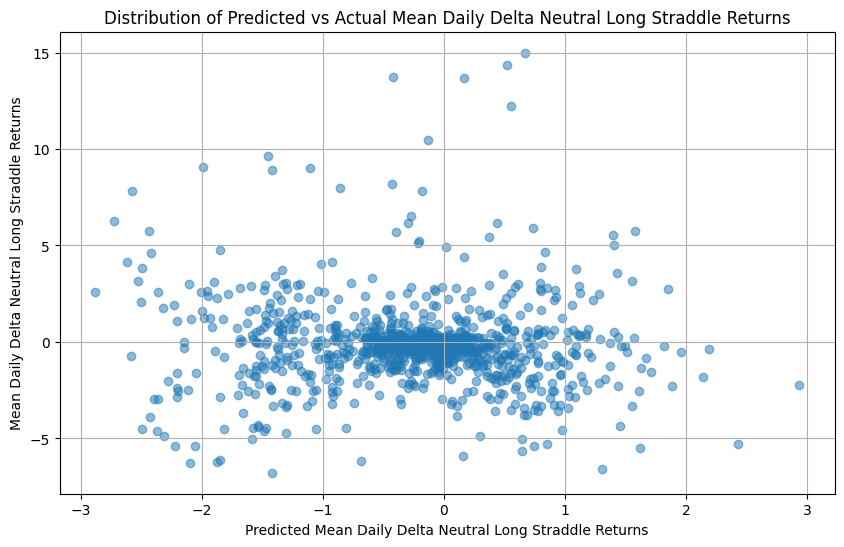

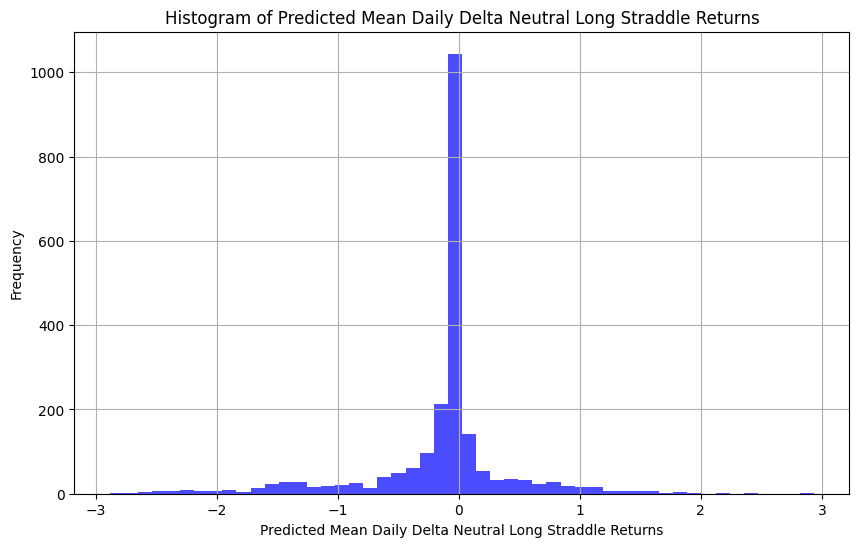

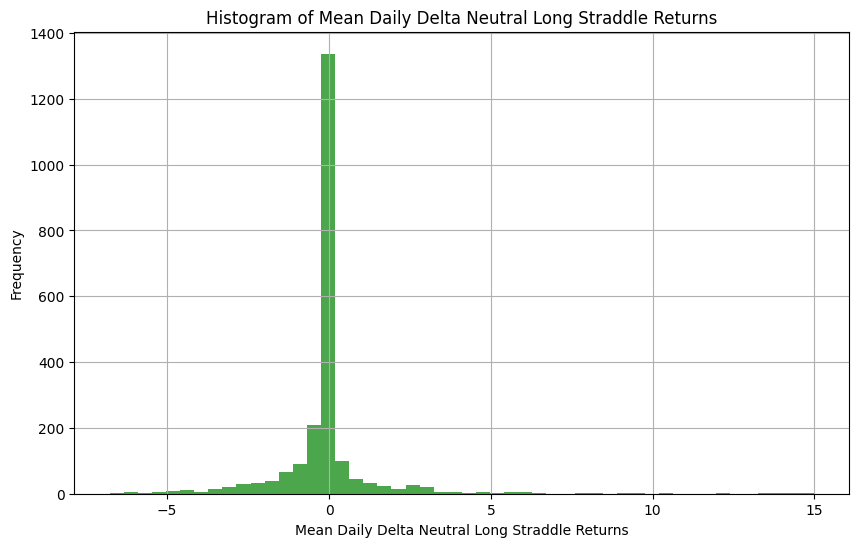

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    return df

def plot_distributions(df):
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['predicted_mean_daily_delta_neutral_long_straddle_returns'], df['mean_daily_delta_neutral_long_straddle_returns'], alpha=0.5)
    plt.xlabel('Predicted Mean Daily Delta Neutral Long Straddle Returns')
    plt.ylabel('Mean Daily Delta Neutral Long Straddle Returns')
    plt.title('Distribution of Predicted vs Actual Mean Daily Delta Neutral Long Straddle Returns')
    plt.grid(True)
    plt.show()

    # Histogram of predicted returns
    plt.figure(figsize=(10, 6))
    plt.hist(df['predicted_mean_daily_delta_neutral_long_straddle_returns'], bins=50, alpha=0.7, color='blue')
    plt.xlabel('Predicted Mean Daily Delta Neutral Long Straddle Returns')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Mean Daily Delta Neutral Long Straddle Returns')
    plt.grid(True)
    plt.show()

    # Histogram of actual returns
    plt.figure(figsize=(10, 6))
    plt.hist(df['mean_daily_delta_neutral_long_straddle_returns'], bins=50, alpha=0.7, color='green')
    plt.xlabel('Mean Daily Delta Neutral Long Straddle Returns')
    plt.ylabel('Frequency')
    plt.title('Histogram of Mean Daily Delta Neutral Long Straddle Returns')
    plt.grid(True)
    plt.show()

# Load the data
data_path = 'final_straddle_data_raw_with_predictions_knn.csv'
df = load_data(data_path)

# Plot the distributions
plot_distributions(df)



Total Amount Invested: $480000.00
Total Returns: $16172.03
Total Return Percentage: 3.37%


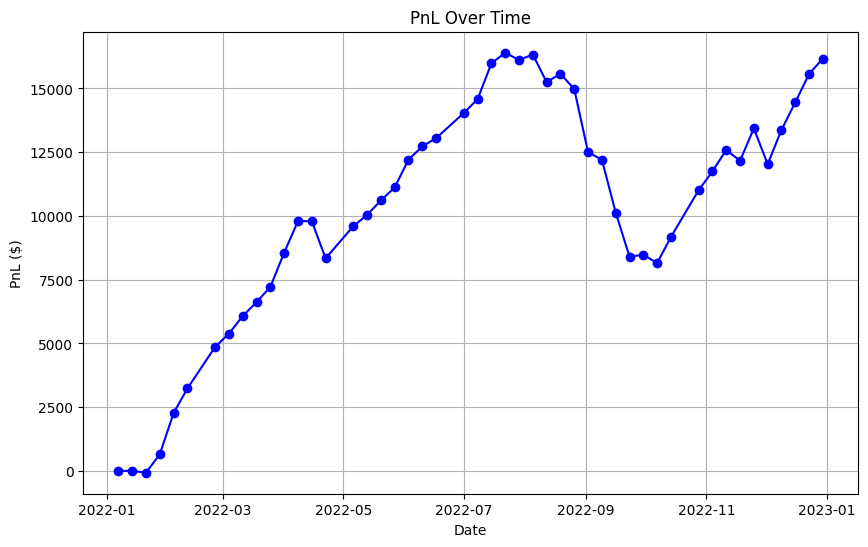

In [4]:
### Long Short Strategy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    return df

def trading_algorithm(df, long_threshold, short_threshold):
    initial_investment = 10000
    cumulative_pnl = 0
    total_investments = 0
    pnl_over_time = []
    log = []
    pending_pnl = {}

    df = df.sort_values(by='date')

    df = df.set_index('date').resample('W-FRI', label='left', closed='left').apply(lambda x: x)
    df = df.reset_index()

    weekly_dates = df['date'].unique()

    for date in weekly_dates:
        # Realize PnL for expiring options
        if date in pending_pnl:
            cumulative_pnl += pending_pnl[date]
            del pending_pnl[date]

        weekly_df = df[df['date'] == date]
        
        # Long straddles
        qualifying_long_straddles = weekly_df[weekly_df['predicted_mean_daily_delta_neutral_long_straddle_returns'] > long_threshold]
        # Short straddles
        qualifying_short_straddles = weekly_df[weekly_df['predicted_mean_daily_delta_neutral_long_straddle_returns'] < -short_threshold]

        # Process long straddles
        if not qualifying_long_straddles.empty:
            num_long_straddles = len(qualifying_long_straddles)
            investment_per_straddle = initial_investment / num_long_straddles
            total_long_invested = 0
            total_long_weekly_returns = 0
            num_2_week_straddles = 0
            num_4_week_straddles = 0

            for _, straddle in qualifying_long_straddles.iterrows():
                straddle_cost = straddle['mid_call'] + straddle['mid_put']
                amount_invested = investment_per_straddle
                actual_return = straddle['delta_neutral_long_straddle_returns'] / 100
                trade_return = amount_invested * actual_return

                total_long_invested += amount_invested
                total_long_weekly_returns += trade_return

                expiration_date = date + pd.DateOffset(weeks=4) if straddle['4_week_option'] == 1 else date + pd.DateOffset(weeks=2)
                if expiration_date not in pending_pnl:
                    pending_pnl[expiration_date] = 0
                pending_pnl[expiration_date] += trade_return

                if straddle['4_week_option'] == 1:
                    num_4_week_straddles += 1
                else:
                    num_2_week_straddles += 1

            total_investments += initial_investment
            total_weekly_return_percentage = (total_long_weekly_returns / initial_investment) * 100

            weekly_log = {
                'week_start_date': date,
                'num_straddles_longed': num_long_straddles,
                'num_2_week_straddles_longed': num_2_week_straddles,
                'num_4_week_straddles_longed': num_4_week_straddles,
                'total_amount_invested_long': total_long_invested,
                'total_returns_once_all_options_expire_long_dollars': total_long_weekly_returns,
                'total_returns_once_all_options_expire_long_percentage': total_weekly_return_percentage
            }
            log.append(weekly_log)

        # Process short straddles
        if not qualifying_short_straddles.empty:
            num_short_straddles = len(qualifying_short_straddles)
            investment_per_straddle = initial_investment / num_short_straddles
            total_short_invested = 0
            total_short_weekly_returns = 0
            num_2_week_straddles = 0
            num_4_week_straddles = 0

            for _, straddle in qualifying_short_straddles.iterrows():
                straddle_cost = straddle['mid_call'] + straddle['mid_put']
                amount_invested = investment_per_straddle
                actual_return = straddle['delta_neutral_long_straddle_returns'] / 100
                trade_return = -amount_invested * actual_return  # Shorting profit is the negative of longing profit

                total_short_invested += amount_invested
                total_short_weekly_returns += trade_return

                expiration_date = date + pd.DateOffset(weeks=4) if straddle['4_week_option'] == 1 else date + pd.DateOffset(weeks=2)
                if expiration_date not in pending_pnl:
                    pending_pnl[expiration_date] = 0
                pending_pnl[expiration_date] += trade_return

                if straddle['4_week_option'] == 1:
                    num_4_week_straddles += 1
                else:
                    num_2_week_straddles += 1

            total_investments += initial_investment
            total_weekly_return_percentage = (total_short_weekly_returns / initial_investment) * 100

            weekly_log = {
                'week_start_date': date,
                'num_straddles_shorted': num_short_straddles,
                'num_2_week_straddles_shorted': num_2_week_straddles,
                'num_4_week_straddles_shorted': num_4_week_straddles,
                'total_amount_invested_short': total_short_invested,
                'total_returns_once_all_options_expire_short_dollars': total_short_weekly_returns,
                'total_returns_once_all_options_expire_short_percentage': total_weekly_return_percentage
            }
            log.append(weekly_log)

        pnl_over_time.append({'date': date, 'cumulative_pnl': cumulative_pnl})

    total_return_dollars = cumulative_pnl
    total_return_percentage = (cumulative_pnl / total_investments) * 100 if total_investments > 0 else 0
    return total_investments, total_return_dollars, total_return_percentage, log, pnl_over_time

def plot_pnl(pnl_over_time):
    dates = [entry['date'] for entry in pnl_over_time]
    pnl_values = [entry['cumulative_pnl'] for entry in pnl_over_time]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, pnl_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Date')
    plt.ylabel('PnL ($)')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.show()

def run_backtest(data_path, long_threshold, short_threshold):
    df = load_data(data_path)
    total_investments, total_return_dollars, total_return_percentage, log, pnl_over_time = trading_algorithm(df, long_threshold, short_threshold)
    
    print(f"Total Amount Invested: ${total_investments:.2f}")
    print(f"Total Returns: ${total_return_dollars:.2f}")
    print(f"Total Return Percentage: {total_return_percentage:.2f}%")

    with open('trading_log.txt', 'w') as f:
        for entry in log:
            f.write(f"Week starting on {entry['week_start_date']}:\n")
            if 'num_straddles_longed' in entry:
                f.write(f"  Number of Straddles Longed: {entry['num_straddles_longed']}\n")
                f.write(f"  Number of 2-Week Straddles Longed: {entry['num_2_week_straddles_longed']}\n")
                f.write(f"  Number of 4-Week Straddles Longed: {entry['num_4_week_straddles_longed']}\n")
                f.write(f"  Total Amount Invested Long: ${entry['total_amount_invested_long']:.2f}\n")
                f.write(f"  Total Returns Once All Options Expire Long: ${entry['total_returns_once_all_options_expire_long_dollars']:.2f} "
                        f"({entry['total_returns_once_all_options_expire_long_percentage']:.2f}%)\n")
            if 'num_straddles_shorted' in entry:
                f.write(f"  Number of Straddles Shorted: {entry['num_straddles_shorted']}\n")
                f.write(f"  Number of 2-Week Straddles Shorted: {entry['num_2_week_straddles_shorted']}\n")
                f.write(f"  Number of 4-Week Straddles Shorted: {entry['num_4_week_straddles_shorted']}\n")
                f.write(f"  Total Amount Invested Short: ${entry['total_amount_invested_short']:.2f}\n")
                f.write(f"  Total Returns Once All Options Expire Short: ${entry['total_returns_once_all_options_expire_short_dollars']:.2f} "
                        f"({entry['total_returns_once_all_options_expire_short_percentage']:.2f}%)\n")
            f.write("\n")

    plot_pnl(pnl_over_time)

data_path = 'final_straddle_data_raw_plus_RFpredictions_v2022.csv'
long_threshold = .3
short_threshold = -0.3

run_backtest(data_path, long_threshold, short_threshold)


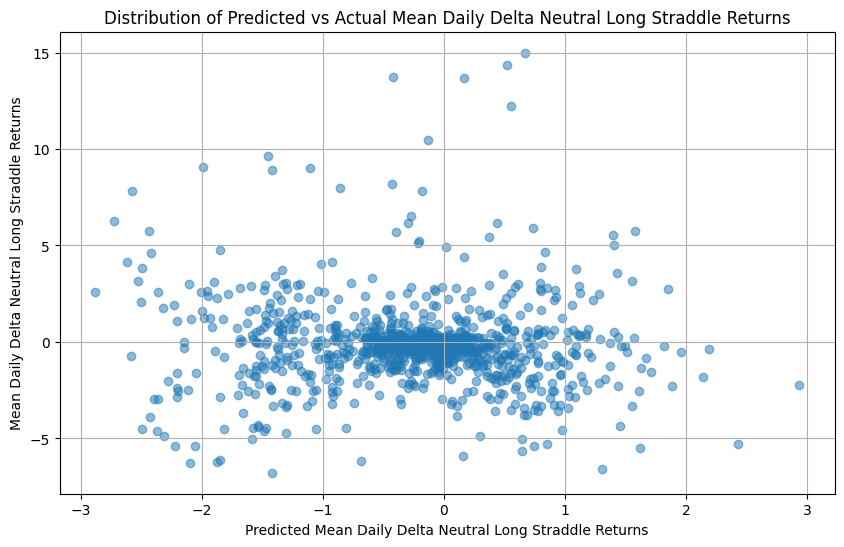

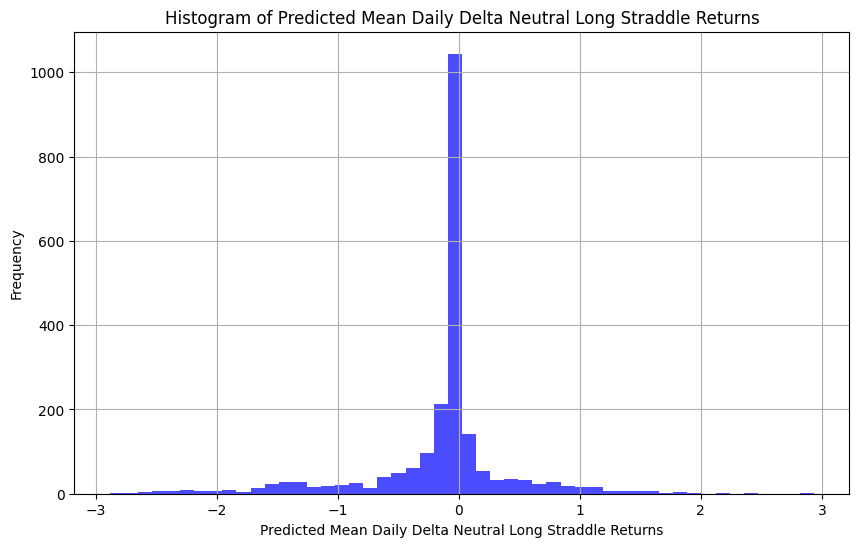

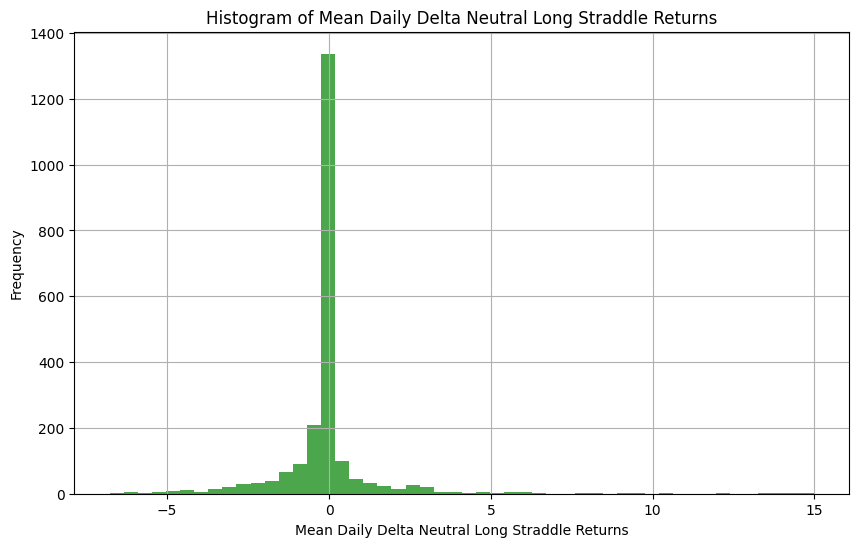

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    return df

def plot_distributions(df):
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['predicted_mean_daily_delta_neutral_long_straddle_returns'], df['mean_daily_delta_neutral_long_straddle_returns'], alpha=0.5)
    plt.xlabel('Predicted Mean Daily Delta Neutral Long Straddle Returns')
    plt.ylabel('Mean Daily Delta Neutral Long Straddle Returns')
    plt.title('Distribution of Predicted vs Actual Mean Daily Delta Neutral Long Straddle Returns')
    plt.grid(True)
    plt.show()

    # Histogram of predicted returns
    plt.figure(figsize=(10, 6))
    plt.hist(df['predicted_mean_daily_delta_neutral_long_straddle_returns'], bins=50, alpha=0.7, color='blue')
    plt.xlabel('Predicted Mean Daily Delta Neutral Long Straddle Returns')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Mean Daily Delta Neutral Long Straddle Returns')
    plt.grid(True)
    plt.show()

    # Histogram of actual returns
    plt.figure(figsize=(10, 6))
    plt.hist(df['mean_daily_delta_neutral_long_straddle_returns'], bins=50, alpha=0.7, color='green')
    plt.xlabel('Mean Daily Delta Neutral Long Straddle Returns')
    plt.ylabel('Frequency')
    plt.title('Histogram of Mean Daily Delta Neutral Long Straddle Returns')
    plt.grid(True)
    plt.show()

# Load the data
data_path = 'final_straddle_data_raw_with_predictions_knn.csv'
df = load_data(data_path)

# Plot the distributions
plot_distributions(df)

